In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy 
from statsmodels.stats.proportion import multinomial_proportions_confint

In [ ]:
os.chdir('..')

In [163]:
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [13]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [302]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
df = original_df.copy()
print(df.shape)

(2577, 121)

In [301]:
df_ss = df.copy()
df_ss['Spontaneous Semiology (SS)'] = df_ss['Spontaneous Semiology (SS)'].replace('y', 1)
df_ss = df_ss[df_ss['Spontaneous Semiology (SS)']==True]
print(df_ss.shape)

(1263, 121)

In [ ]:
semiology_list = list(recursive_items(SemioDict))

In [16]:
semiology_query_results = {}
for semiology in semiology_list:
    query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                 semiology_term=semiology,
                                                                 ignore_case=True,
                                                                 semiology_dict_path=None,
                                                                 all_columns_wanted = True)
                                                                         # col1=col1, col2=col1)
    one_query_result = {
        'query_inspection': query_inspection,
        'num_query_lat': num_query_lat,
        'num_query_loc': num_query_loc
    }
    semiology_query_results[semiology] = one_query_result

In [248]:
n_results = []
for k, v in semiology_query_results.items():
    n_results.append(v['num_query_loc'])
n_results = np.array(n_results)
top_10_semiologies = np.array(semiology_list)[(n_results>170)]

In [249]:
top_10_semiologies

array(['Epigastric', 'Psychic', 'Somatosensory', 'Non-Specific Aura',
       'Head Version', 'Tonic', 'Dystonic', 'Clonic', 'Hypermotor',
       'Aphasia'], dtype='<U47')

In [259]:
top_level = top_level_lobes()
n_top_level_lobes = len(top_level)
top_level_of_interest = [
                         'TL',
                         'FL',
                         'PL',
                         'OL',
                         'INSULA',
                         'CING',
                         'Hypothalamus',
                        ]
top_level_all_other = list(set(top_level) - set(top_level_of_interest))
top_level_of_interest_minus_tl = list(set(top_level_of_interest) - set(['TL']))

low_level_temporal_all =  [y for x in temporal_postcodes.values() for y in x]
low_level_temporal_of_interest = ['Mesial Temporal',
                        'Lateral Temporal',
                        'Anterior (temporal pole)',
                        'Posterior Temporal',
                        'Basal (including Fusiform OTMG)']

low_level_temporal_other =  list(set(all_low_level_temporal) - set(low_level_temporal_of_interest))

In [274]:
#TODO - group basal inc. OTMG (fusiform)'
#TODO discard other temporal categories
#TODO proportion_confint - coun Nobs = total for semiology
# Order - as in df
# bootstrapping
# divide by all cases in a region
# plot spontaneous semiology ONLY on top/below normal 

In [266]:
region_names = {'top_level': top_level,
                'of_interest': top_level_of_interest,
                'of_interest_minus_tl': top_level_of_interest_minus_tl,
                'top_level_all_other': top_level_all_other,
                'top_level_temporal': ['TL'],
                'low_level_temporal_all': low_level_temporal_all,
                'low_level_temporal_of_interest': low_level_temporal_of_interest,
                'low_level_temporal_other': low_level_temporal_other}

In [35]:
def get_proportions(values):
    sum_values = np.sum(values)
    proportions = [value/sum_values for value in values]
    return proportions

In [ ]:
for semiology, value in semiology_query_results.items():
    query_inspection = value['query_inspection']
    low_level_sum = query_inspection[region_names['low_level_temporal']].sum().sum()
    total_tl = query_inspection['TL'].sum()
    other_temporal = total_tl-low_level_sum
    print('Semiology:', semiology,
          'Total TL: ', total_tl,
          'Lower level sum: ', low_level_sum, 
          'Other temporal: ', other_temporal)

In [267]:
region_names['top_level_all_other']

['Cerebellum',
 'FTP',
 'TPO Junction',
 'TP',
 'TO',
 'Sub-Callosal Cortex',
 'FT',
 'FP',
 'Perisylvian',
 'PO']

In [270]:
def calculate_proportions_and_ci(query_results, region_names, other_included = False, merge_temporal = False):
    for semiology, value in query_results.items():
#         print(region_names_update)
        query_inspection = query_results[semiology]['query_inspection']
        if merge_temporal == False:
            region_names_update = region_names['of_interest_minus_tl'] + region_names['low_level_temporal_of_interest']
            by_zone_minus_temporal = np.array(query_inspection[region_names['of_interest_minus_tl']].sum(0))
            by_zone_temporal = np.array(query_inspection[region_names['low_level_temporal_of_interest']].sum(0))
            by_zone = np.append(by_zone_minus_temporal, by_zone_temporal)
#             all_other_temporal  = query_inspection[region_names['low_level_temporal_other']].sum(0).sum()
        else:
            region_names_update = copy.deepcopy(region_names['of_interest'])
            by_zone = np.array(query_inspection[region_names['of_interest']].sum(0))
            
        if other_included:
            region_names_update += ['Any other']
            all_other_zones = query_inspection[region_names['top_level_all_other']].sum(0).sum()
#             try:
#                 all_other_zones += all_other_temporal
#             except NameError:
#                 pass
            by_zone = np.append(by_zone, all_other_zones)
            
        proportions = get_proportions(by_zone)
        confint = multinomial_proportions_confint(by_zone, alpha=0.05, method='sison-glaz') #sison-glaz throws error?!
        ci = confint[:,1] - confint[:,0]

        query_results[semiology]['by_zone'] = by_zone
        query_results[semiology]['proportions'] = proportions
        query_results[semiology]['confint'] = confint
        query_results[semiology]['ci'] = ci
        query_results[semiology]['semiology_name'] = semiology
        query_results[semiology]['region_names'] = region_names_update

    return query_results

In [271]:
standard_qr = copy.deepcopy(semiology_query_results)
standard_qr = calculate_proportions_and_ci(standard_qr, region_names, other_included = False, merge_temporal = False, )

<ipython-input-35-94f6c7b79efe>:3: RuntimeWarning: invalid value encountered in double_scalars
  proportions = [value/sum_values for value in values]
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:257: RuntimeWarning: invalid value encountered in true_divide
  proportions = counts / n
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:303: RuntimeWarning: invalid value encountered in double_scalars
  g1 = mu3.sum() / mu2.sum() ** 1.5
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:304: RuntimeWarning: invalid value encountered in double_scalars
  g2 = (mu4.sum() - 3 * (mu2 ** 2).sum()) / mu2.sum() ** 2
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:307: RuntimeWarning: invalid value encountered in double_scalars
  x = (n - mu.sum()) / np.sqrt(mu2.sum())


Exception: Couldn't find a value for `c` that solves nu(c) <= 1 - alpha < nu(c + 1)

In [280]:
other_qr['Epigastric']['confint']

array([[2.37251958e-02, 5.45807919e-02],
       [4.58225638e-03, 2.20087732e-02],
       [5.11364868e-03, 2.31456053e-02],
       [1.45949039e-02, 4.03559414e-02],
       [1.28468276e-03, 1.36287756e-02],
       [3.36871381e-01, 4.15397287e-01],
       [3.05112183e-02, 6.44770139e-02],
       [2.08756352e-01, 2.78264628e-01],
       [8.58827459e-05, 8.15467778e-03],
       [2.18289782e-01, 2.88749891e-01]])

In [209]:
other_qr = copy.deepcopy(semiology_query_results)
other_qr = calculate_proportions_and_ci(other_qr, region_names, other_included = True, merge_temporal = False)

<ipython-input-35-94f6c7b79efe>:3: RuntimeWarning: invalid value encountered in double_scalars
  proportions = [value/sum_values for value in values]


In [210]:
temporal_other_qr = copy.deepcopy(semiology_query_results)
temporal_other_qr = calculate_proportions_and_ci(temporal_other_qr, region_names, other_included = True, merge_temporal=True)

<ipython-input-35-94f6c7b79efe>:3: RuntimeWarning: invalid value encountered in double_scalars
  proportions = [value/sum_values for value in values]


In [272]:
def plot_semiology(query_result, ax=None):
    x = query_result['proportions']
    y = query_result['region_names']
    xerr = query_result['confint'].T
    sns.pointplot(x=x,
                y=y,
                join=False,
                ci=False,
                ax=ax,
                color="#42847D",
                scale = 0.9)
    ax.errorbar(x, y, xerr=xerr, ls='none', color='#42847D')
    ax.title.set_text(query_result['semiology_name'])
    ax.axvline(x=1/len(x),ymin=0,ymax=1,c="darksalmon", linewidth=1, zorder=0, clip_on=False)

Text(0.5,0.07,'P(localisation | semiology)')

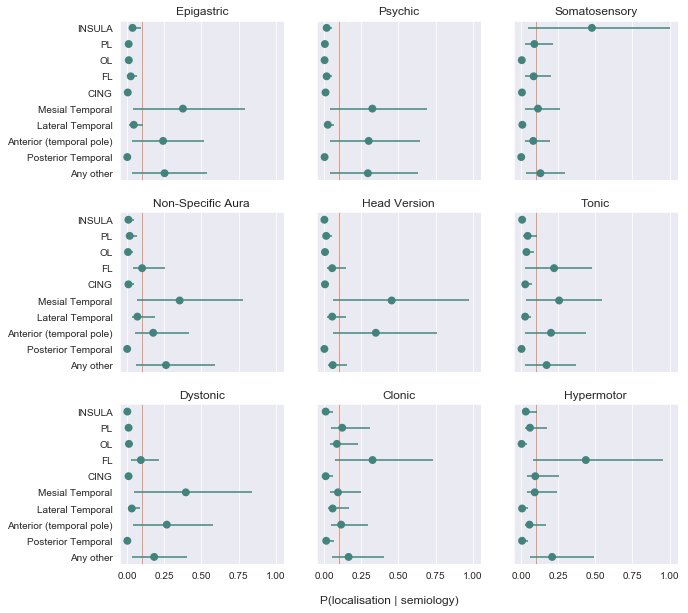

In [291]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
for i, semiology in enumerate(top_10_semiologies[:9]):
    coord = divmod(i, 3)
    plot_semiology(other_qr[semiology], axs[coord[0], coord[1]])
    
fig.text(0.5, 0.07, 'P(localisation | semiology)', ha='center', fontsize=12)
# plt.vlines(1/55, 0, 1)

In [236]:
n_top_level_lobes

17

In [ ]:
regions_of_interest = ['Mesial Temporal',
                         'Lateral Temporal',
                         'Anterior (temporal pole)',
                         'Posterior Temporal',
                         'TL',
                         'FL',
                         'PL',
                         'OL',
                         'INSULA',
                         'CING',
                        ]
# regions_of_interest.sort()
temporal_regions = ['Anterior (temporal pole)',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal']



In [ ]:
all_regions = """TL
Anterior (temporal pole)
Lateral Temporal
STG (includes Transverse Temporal Gyrus, Both Planum)
Transverse Temporal Gyrus (Heschl's, BA 41,  42, ?opercula)
Planum Temporale
Planum Polare
MTG
ITG
Mesial Temporal
Ant Mesial Temporal
Post Mesial Temporal
Enthorinal Cortex
Fusiform
AMYGD
PARAHIPPOCAMPUS
HIPPOCAMPUS
Posterior Temporal
Basal (including Fusiform OTMG)
OTMG (fusiform)
FL
frontal pole
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)
DL-PFC (BA 46) (include subgroups BA 9, 8, 10 - frontopolar/anterior prefrontal)
gyrus rectus (basal = gyrus rectus and OFC)
Orbito-frontal (BA 10, 11, 12/47) (basal = gyrus rectus and OFC)
Post OF
Lat OF
Med OF
Medial Frontal (include medial premotor and its constituents as its subsets)
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)
medial precentral
Rolandic Operculum (low BA4)
SFG (F1)
Med SFG
Post SFG
Ant SFG
MFG (F2)
Ant MFG
Mid MFG
Post MFG
Pars Triangularis (subgroup IFG)
Pars opercularis (BA 44)(subgroup IFG, ?opercula)
Premotor frontal (posterior frontal)
Ant Premotor (BA 8, frontal-eye-fields)
Medial Premotor (including pre SMA)
SMA (pre-central gyrus; posterior SFG, MFG)
SSMA
CING
Cingulum (WM)
Ant Cing (frontal, genu)
Dorsal Ant Cing (BA 32)
Middle Cingulate
Post Cing
Isthmus
PL
Primary Sensory Cortex (post-central gyrus)
medial anterior parietal
Sup. pariet. lobule
Precuneus (medial post sup parietal lobule)
Inferior Parietal Lobule
Supramarg gyrus (post part of parietal operculum)
Angular gyrus (BA 39)
parietal operculum (ceiling of secondary somatosensory cortex)
OL
Mesial Occipital
Lingual gyrus  (medial and basal)
Cuneus
Lateral Occipital (SOG, IOG, LOG)
Posterior Occipital Gyrus
Superior Occipital Gyrus
INSULA
Ant Ins
Anterior Short Gyrus
Middle Short Gyrus
Post short gyrus
Precentral gyrus
Postcentral gyrus
Posterior long gyrus
Hypothalamus
Sub-Callosal Cortex
Cerebellum
Hemisphere
Vermis
FT
TO
TP
FTP
TPO Junction
PO
FP
Perisylvian""".splitlines()

all_regions += ['''IFG (F3)
(BA 44,45,47)''',
'''Lateral Premotor
(BA 6)''',
'''Pars orbitalis (subgroup of IFG)
(BA 47)''']
# '''Pars opercularis (BA 44)(subgroup IFG, ?opercula)'''

In [ ]:
other_regions = set(all_regions) - set(regions_of_interest)
other_regions = list(other_regions)

regions_of_interest_minus_temporal = set(regions_of_interest) - set(temporal_regions)
regions_of_interest_minus_temporal = list(regions_of_interest_minus_temporal)